# Predicting Appointment No-Shows

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

In [3]:
no_show = pd.read_csv('no_show.csv')

In [4]:
no_show

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [5]:
no_show.to_csv('No_Show_Data.csv')

In [6]:
print('Total appointments: ' + format(no_show.shape[0], ",d"))
print('Distinct patients: ' + format(no_show['PatientId'].unique().shape[0], ",d"))

Total appointments: 110,527
Distinct patients: 62,299


In [7]:
no_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [8]:
no_show.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

## Feature Engineering

In [9]:
noshow_map = {'Yes': 1, 'No': 0}
no_show['No_Show'] = no_show['No-show'].map(noshow_map)

In [10]:
no_show['PatientId']=no_show['PatientId'].astype(int)

In [11]:
no_show['ScheduledDay']=pd.to_datetime(no_show['ScheduledDay'])

In [12]:
no_show['AppointmentDay']=pd.to_datetime(no_show['AppointmentDay'])

In [13]:
no_show['Sch_Day_of_the_Week'] = no_show['ScheduledDay'].dt.weekday_name

In [14]:
no_show['App_Day_of_the_Week'] = no_show['AppointmentDay'].dt.weekday_name

In [15]:
no_show['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [16]:
no_show['App_Day_of_the_Week'].value_counts()

Wednesday    25867
Tuesday      25640
Monday       22715
Friday       19019
Thursday     17247
Saturday        39
Name: App_Day_of_the_Week, dtype: int64

In [17]:
no_show['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [18]:
no_show['Handcap']=(no_show['Handcap'] > 0)*1

In [19]:
no_show['Has_Handicap']=no_show['Handcap']

In [20]:
no_show['Hipertension'].value_counts()

0    88726
1    21801
Name: Hipertension, dtype: int64

In [21]:
no_show['Hypertension']=no_show['Hipertension']

In [22]:
no_show['Sch_Date']=no_show['ScheduledDay'].dt.date

In [23]:
no_show['App_Date']=no_show['AppointmentDay'].dt.date

In [24]:
no_show['PreviousApp'] = no_show.sort_values(by = ['PatientId','App_Date']).groupby(['PatientId']).cumcount()

no_show['Cum_NoShow'] = no_show.sort_values(['App_Date']).groupby(['PatientId'])['No_Show'].cumsum()

no_show['Avg_PreviousNoShow'] = (no_show[no_show['PreviousApp'] > 0].sort_values(['PatientId', 'App_Date']).groupby(['PatientId'])['No_Show'].cumsum() / no_show[no_show['PreviousApp'] > 0]['PreviousApp'])

In [25]:
no_show['Avg_PreviousNoShow'].fillna(0,inplace=True)

In [26]:
no_show['Avg_PreviousNoShow'].value_counts()

0.000000    94219
1.000000     6195
0.500000     3542
0.333333     1765
0.250000      923
            ...  
0.011905        1
0.900000        1
0.013699        1
0.029851        1
0.032787        1
Name: Avg_PreviousNoShow, Length: 239, dtype: int64

In [27]:
no_show['Days_Between']=no_show['App_Date']-no_show['Sch_Date']

In [28]:
no_show['Days_Between']=no_show['Days_Between'].dt.days

In [29]:
no_show['Days_Between'].value_counts()
#Need to group these and remove negatives

 0      38563
 2       6725
 4       5290
 1       5213
 7       4906
        ...  
 117        1
 146        1
 82         1
-6          1
 127        1
Name: Days_Between, Length: 131, dtype: int64

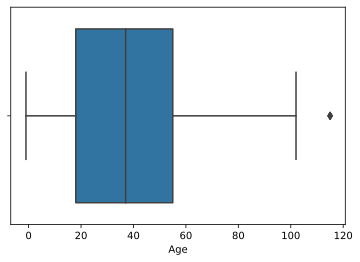

In [30]:
sns.boxplot(no_show['Age'])

In [31]:
df1_before_dummies=no_show.loc[:,['No_Show','Gender', 'Age', 'Scholarship', 'Diabetes', 'Alcoholism',
       'Has_Handicap','Hypertension', 'Days_Between','Sch_Day_of_the_Week', 'App_Day_of_the_Week','SMS_received',
        'PreviousApp','Cum_NoShow']]

In [32]:
df1_before_dummies.head()

,No_Show,Gender,Age,Scholarship,Diabetes,Alcoholism,Has_Handicap,Hypertension,Days_Between,Sch_Day_of_the_Week,App_Day_of_the_Week,SMS_received,PreviousApp,Cum_NoShow
0,0,F,62,0,0,0,0,1,0,Friday,Friday,0,0,0
1,0,M,56,0,0,0,0,0,0,Friday,Friday,0,0,0
2,0,F,62,0,0,0,0,0,0,Friday,Friday,0,0,0
3,0,F,8,0,0,0,0,0,0,Friday,Friday,0,0,0
4,0,F,56,0,1,0,0,1,0,Friday,Friday,0,0,0


In [33]:
df1_before_dummies=df1_before_dummies.loc[df1_before_dummies['Days_Between']>=0,:]

In [34]:
df1_before_dummies=df1_before_dummies.loc[df1_before_dummies['Age']>=0,:]

In [35]:
df1_before_dummies=df1_before_dummies.loc[df1_before_dummies['Age']<115,:]

In [36]:
df1_before_dummies=df1_before_dummies.loc[df1_before_dummies['App_Day_of_the_Week']!='Saturday',:]

In [37]:
df1_before_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110477 entries, 0 to 110526
Data columns (total 14 columns):
No_Show                110477 non-null int64
Gender                 110477 non-null object
Age                    110477 non-null int64
Scholarship            110477 non-null int64
Diabetes               110477 non-null int64
Alcoholism             110477 non-null int64
Has_Handicap           110477 non-null int64
Hypertension           110477 non-null int64
Days_Between           110477 non-null int64
Sch_Day_of_the_Week    110477 non-null object
App_Day_of_the_Week    110477 non-null object
SMS_received           110477 non-null int64
PreviousApp            110477 non-null int64
Cum_NoShow             110477 non-null int64
dtypes: int64(11), object(3)
memory usage: 12.6+ MB


In [38]:
df1_with_dummies=pd.get_dummies(df1_before_dummies,columns=['Gender','Sch_Day_of_the_Week','App_Day_of_the_Week'],drop_first=True)

In [39]:
df1_with_dummies.columns

Index(['No_Show', 'Age', 'Scholarship', 'Diabetes', 'Alcoholism',
       'Has_Handicap', 'Hypertension', 'Days_Between', 'SMS_received',
       'PreviousApp', 'Cum_NoShow', 'Gender_M', 'Sch_Day_of_the_Week_Monday',
       'Sch_Day_of_the_Week_Saturday', 'Sch_Day_of_the_Week_Thursday',
       'Sch_Day_of_the_Week_Tuesday', 'Sch_Day_of_the_Week_Wednesday',
       'App_Day_of_the_Week_Monday', 'App_Day_of_the_Week_Thursday',
       'App_Day_of_the_Week_Tuesday', 'App_Day_of_the_Week_Wednesday'],
      dtype='object')

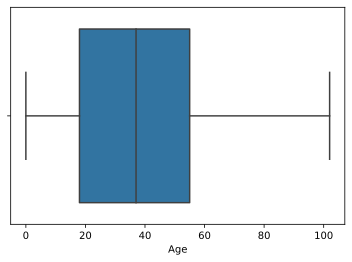

In [40]:
sns.boxplot(df1_with_dummies['Age'])

In [41]:
df1_with_dummies.columns

Index(['No_Show', 'Age', 'Scholarship', 'Diabetes', 'Alcoholism',
       'Has_Handicap', 'Hypertension', 'Days_Between', 'SMS_received',
       'PreviousApp', 'Cum_NoShow', 'Gender_M', 'Sch_Day_of_the_Week_Monday',
       'Sch_Day_of_the_Week_Saturday', 'Sch_Day_of_the_Week_Thursday',
       'Sch_Day_of_the_Week_Tuesday', 'Sch_Day_of_the_Week_Wednesday',
       'App_Day_of_the_Week_Monday', 'App_Day_of_the_Week_Thursday',
       'App_Day_of_the_Week_Tuesday', 'App_Day_of_the_Week_Wednesday'],
      dtype='object')

In [116]:
df1_with_dummies['No_Show'].value_counts()

0    88175
1    22302
Name: No_Show, dtype: int64

## Modeling

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X=pd.DataFrame(df1_with_dummies,columns=['Age', 'Scholarship', 'Diabetes', 'Alcoholism', 'Has_Handicap',
       'Hypertension', 'Days_Between', 'SMS_received', 'PreviousApp',
       'Cum_NoShow', 'Gender_M', 'Sch_Day_of_the_Week_Monday',
       'Sch_Day_of_the_Week_Saturday', 'Sch_Day_of_the_Week_Thursday',
       'Sch_Day_of_the_Week_Tuesday', 'Sch_Day_of_the_Week_Wednesday',
       'App_Day_of_the_Week_Monday', 'App_Day_of_the_Week_Thursday',
       'App_Day_of_the_Week_Tuesday', 'App_Day_of_the_Week_Wednesday'])

y = df1_with_dummies['No_Show']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [44]:
features=['Age', 'Scholarship', 'Diabetes', 'Alcoholism', 'Has_Handicap',
       'Hypertension', 'Days_Between', 'SMS_received', 'PreviousApp',
       'Cum_NoShow', 'Gender_M', 'Sch_Day_of_the_Week_Monday',
       'Sch_Day_of_the_Week_Saturday', 'Sch_Day_of_the_Week_Thursday',
       'Sch_Day_of_the_Week_Tuesday', 'Sch_Day_of_the_Week_Wednesday',
       'App_Day_of_the_Week_Monday', 'App_Day_of_the_Week_Thursday',
       'App_Day_of_the_Week_Tuesday', 'App_Day_of_the_Week_Wednesday']

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=10)

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [47]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=10)
X_resampled, y_resampled = ros.fit_sample(X_train_scaled,y_train)

Using TensorFlow backend.


In [48]:
Counter(y_resampled)

Counter({0: 52940, 1: 52940})

#### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

/Users/juliusmagsino/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
predictions = logmodel.predict(X_val_scaled)

In [52]:
from sklearn.metrics import classification_report,confusion_matrix

Logistic Regression

In [53]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     17579
           1       0.72      0.97      0.83      4517

    accuracy                           0.92     22096
   macro avg       0.86      0.94      0.89     22096
weighted avg       0.94      0.92      0.92     22096



In [122]:
from sklearn import metrics
print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_val, predictions))

Balanced Accuracy: 0.937829


In [55]:
print(confusion_matrix(y_val,predictions))

[[15903  1676]
 [  131  4386]]


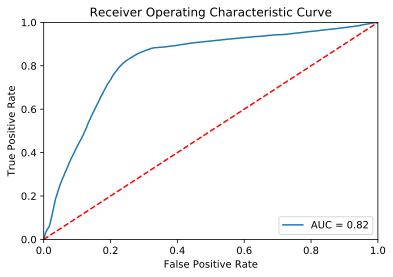

In [106]:
# ROC Curve 
probs_log = logmodel.predict_proba(df1_with_dummies[features])[:,1]

fpr_log, tpr_log, threshold_log = metrics.roc_curve(df1_with_dummies['No_Show'], probs_log)
roc_auc_log = metrics.auc(fpr_log, tpr_log)


plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_log, tpr_log, label = 'AUC = %0.2f' % roc_auc_log)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
rfc_pred = rfc.predict(X_val_scaled)

In [59]:
print(classification_report(y_val,rfc_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     17579
           1       0.80      0.90      0.85      4517

    accuracy                           0.93     22096
   macro avg       0.89      0.92      0.90     22096
weighted avg       0.94      0.93      0.94     22096



In [124]:
print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_val, rfc_pred))

Balanced Accuracy: 0.920414


In [61]:
print(confusion_matrix(y_val,rfc_pred))

[[16575  1004]
 [  461  4056]]


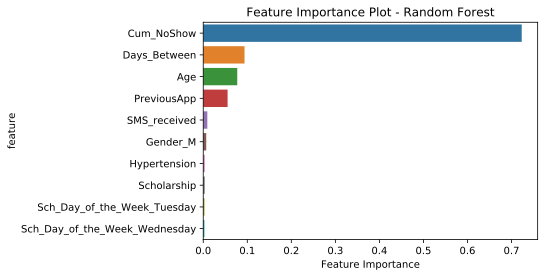

In [62]:
feature_importance = pd.DataFrame({'feature' : features,
                                   'importances' : rfc.feature_importances_})
ordered = feature_importance.sort_values(['importances'], ascending = False)
best = ordered[:10]
sns.barplot(x = 'importances', y = 'feature', data = best)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot - Random Forest')
plt.show()

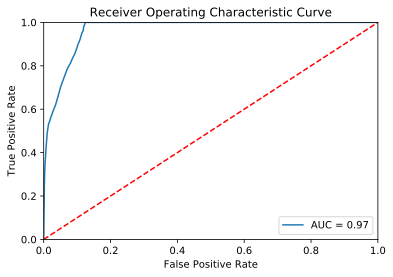

In [105]:
# ROC Curve 
probs_rfc = rfc.predict_proba(df1_with_dummies[features])[:,1]

fpr_rfc, tpr_rfc, threshold_rfc = metrics.roc_curve(df1_with_dummies['No_Show'], probs_rfc)
roc_auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)


plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_rfc, tpr_rfc, label = 'AUC = %0.2f' % roc_auc_rfc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
dtree = DecisionTreeClassifier()

In [70]:
dtree.fit(X_resampled,y_resampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [71]:
dt_pred = dtree.predict(X_val_scaled)

In [72]:
print(classification_report(y_val,dt_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     17579
           1       0.81      0.82      0.82      4517

    accuracy                           0.92     22096
   macro avg       0.88      0.89      0.88     22096
weighted avg       0.92      0.92      0.92     22096



In [73]:
print(confusion_matrix(y_val,dt_pred))

[[16719   860]
 [  812  3705]]


In [123]:
print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_val, dt_pred))

Balanced Accuracy: 0.885656


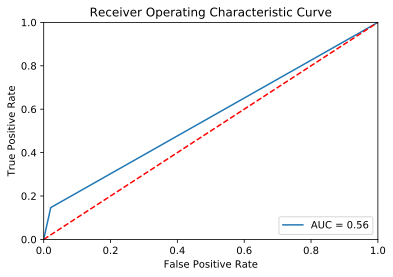

In [107]:
# ROC Curve 
probs_dt = dtree.predict_proba(df1_with_dummies[features])[:,1]

fpr_dt, tpr_dt, threshold = metrics.roc_curve(df1_with_dummies['No_Show'], probs_dt)
roc_auc_dt = metrics.auc(fpr_dt, tpr_dt)


plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_dt, tpr_dt, label = 'AUC = %0.2f' % roc_auc_dt)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### XGBoost

In [75]:
from xgboost import XGBClassifier

In [76]:
xgb = XGBClassifier(max_depth=3,n_estimators=50)

In [77]:
xgb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
xgb_pred = xgb.predict(X_val_scaled)

In [79]:
print(classification_report(y_val,xgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     17579
           1       0.71      0.99      0.83      4517

    accuracy                           0.92     22096
   macro avg       0.86      0.94      0.89     22096
weighted avg       0.94      0.92      0.92     22096



In [80]:
print(confusion_matrix(y_val,xgb_pred))

[[15773  1806]
 [   34  4483]]


In [125]:
print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_val, xgb_pred))

Balanced Accuracy: 0.944868


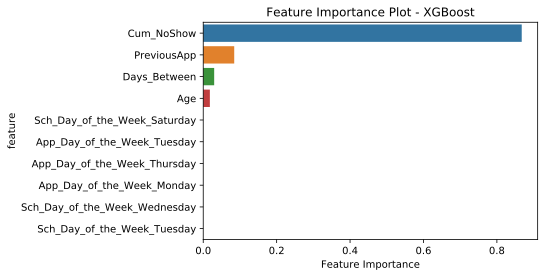

In [82]:
feature_importance = pd.DataFrame({'feature' : features,
                                   'importances' : xgb.feature_importances_})
ordered = feature_importance.sort_values(['importances'], ascending = False)
best = ordered[:10]
sns.barplot(x = 'importances', y = 'feature', data = best,)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot - XGBoost')
plt.show()

#### K Nearest Neighbors

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
knn = KNeighborsClassifier(n_neighbors=2)

In [85]:
knn.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [86]:
knn_pred = knn.predict(X_val_scaled)

In [87]:
print(classification_report(y_val,knn_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     17579
           1       0.80      0.78      0.79      4517

    accuracy                           0.91     22096
   macro avg       0.87      0.86      0.87     22096
weighted avg       0.91      0.91      0.91     22096



In [88]:
print(confusion_matrix(y_val,knn_pred))

[[16683   896]
 [  997  3520]]


In [126]:
print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_val, knn_pred))

Balanced Accuracy: 0.864154


In [90]:
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_resampled,y_resampled)
    pre_i = knn.predict(X_val_scaled)
    error_rate.append(np.mean(pre_i != y_val))

Text(0, 0.5, 'Error Rate')

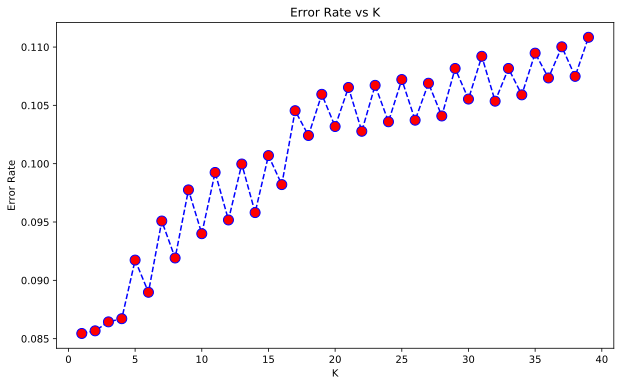

In [91]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='--',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K')
plt.xlabel('K')
plt.ylabel("Error Rate")

#### SVM

In [92]:
from sklearn.svm import SVC

In [93]:
svc_model=SVC()

In [94]:
svc_model.fit(X_resampled,y_resampled)

/Users/juliusmagsino/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [95]:
svc_pred = svc_model.predict(X_val_scaled)

In [96]:
print(classification_report(y_val,svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     17579
           1       0.70      0.99      0.82      4517

    accuracy                           0.91     22096
   macro avg       0.85      0.94      0.88     22096
weighted avg       0.94      0.91      0.92     22096



In [97]:
print(confusion_matrix(y_val,svc_pred))

[[15681  1898]
 [   42  4475]]


In [127]:
print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_val, svc_pred))

Balanced Accuracy: 0.941366


#### SVM GridSearch CV

In [131]:
from sklearn.model_selection import GridSearchCV

In [132]:
param_grid = {'C':[0.1,1,10,100],'gamma':[1,0.1,0.01,0.001]}

In [133]:
grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_resampled,y_resampled)

/Users/juliusmagsino/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 4.9min
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total= 5.1min
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 5.2min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.0min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 1.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.1min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total= 1.8min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total= 1.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 193.9min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [134]:
grid_pred = grid.predict(X_val_scaled)

In [135]:
print(classification_report(y_val,grid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17579
           1       0.78      0.77      0.77      4517

    accuracy                           0.91     22096
   macro avg       0.86      0.86      0.86     22096
weighted avg       0.91      0.91      0.91     22096



In [136]:
print(confusion_matrix(y_val,grid_pred))

[[16585   994]
 [ 1048  3469]]


In [137]:
print("AUC Score: %f" % metrics.roc_auc_score(y_val, grid_pred))

AUC Score: 0.855721


#### XGBoost on Test Data

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     17656
           1       0.72      0.99      0.83      4440

    accuracy                           0.92     22096
   macro avg       0.86      0.95      0.89     22096
weighted avg       0.94      0.92      0.92     22096

[[15942  1714]
 [   40  4400]]
Balanced Accuracy: 0.946957


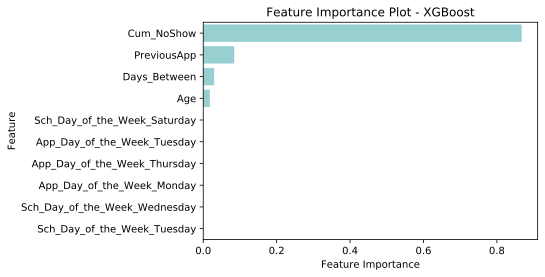

In [120]:
xgb_test_pred = xgb.predict(X_test_scaled)

print(classification_report(y_test,xgb_test_pred))

print(confusion_matrix(y_test,xgb_test_pred))

print("Balanced Accuracy: %f" % metrics.roc_auc_score(y_test, xgb_test_pred))

feature_importance = pd.DataFrame({'feature' : features,
                                   'importances' : xgb.feature_importances_})
ordered = feature_importance.sort_values(['importances'], ascending = False)
best = ordered[:10]
sns.barplot(x = 'importances', y = 'feature', data = best,color='#8ED9DC')
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot - XGBoost')
plt.show()